In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

In [3]:
RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]
dataset = pd.read_csv(r"C:\Users\rautv\Downloads\credit card dataset\creditcard.csv")

In [4]:
#check for any null values
print("Any nulls in the dataset",dataset.isnull().values.any())
print('-------')
print("No. of unique labels",len(dataset['Class'].unique()))
print("Label values",dataset.Class.unique())
#0 is for normal credit card transcation
#1 is for fraudulent credit card transcation
print('-------')
print("Break down of Normal and Fraud Transcations")
print(pd.value_counts(dataset['Class'],sort=True))


Any nulls in the dataset False
-------
No. of unique labels 2
Label values [0 1]
-------
Break down of Normal and Fraud Transcations
0    284315
1       492
Name: Class, dtype: int64


Text(0, 0.5, 'Number of Observations')

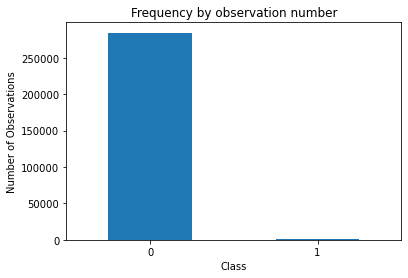

In [6]:
#visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'],sort=True)
count_classes.plot(kind='bar',rot=0)
plt.xticks(range(len(dataset['Class'].unique())),dataset.Class.unique(
))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")


In [7]:
#Save the normal and fradulent transcations in seperate dataframe
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]


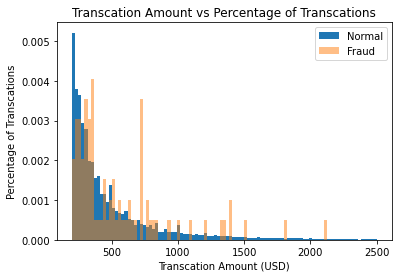

In [9]:
#Visualize transcation amounts for normal and fraudulent transcations
bins = np.linspace(200,2500,100)
plt.hist(normal_dataset.Amount,bins=bins,alpha=1,density=True,label='Normal')
plt.hist(fraud_dataset.Amount,bins=bins,alpha=0.5,density=True,label='Fraud')
plt.legend(loc='upper right')
plt.title("Transcation Amount vs Percentage of Transcations")
plt.xlabel("Transcation Amount (USD)")
plt.ylabel("Percentage of Transcations")
plt.show()

In [10]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
sc = StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1,1))
dataset['Amount'] =sc.fit_transform(dataset['Amount'].values.reshape(-1,1))
raw_data = dataset.values
#The last element contains if the transcation is normal which is 
#represented by 0 and if fraud then 1
labels = raw_data[:,-1]
#The other data points are the electrocadriogram data
data = raw_data[:,0:-1]


In [13]:
train_data,test_data,train_labels,test_labels =train_test_split(data,labels,test_size = 0.2,random_state =2021)

In [14]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [15]:
#Creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print("No. of records in Fraud Train Data=",len(fraud_train_data))
print("No. of records in Normal Train Data=",len(normal_train_data))
print("No. of records in Fraud Test Data=",len(fraud_test_data))
print("No. of records in Normal Test Data=",len(normal_test_data))

No. of records in Fraud Train Data= 389
No. of records in Normal Train Data= 227456
No. of records in Fraud Test Data= 103
No. of records in Normal Test Data= 56859


In [16]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]
#num of columns,30
encoding_dim = 14
hidden_dim1 = int(encoding_dim / 2)
hidden_dim2 = 4
learning_rate = 1e-7
#input layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))


In [28]:
#Encoder
encoder =tf.keras.layers.Dense(encoding_dim,activation="tanh",activity_regularizer = tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)
encoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')

encoder =tf.keras.layers.Dense(hidden_dim2,activation=tf.nn.leaky_relu)


In [29]:
#Decoder
decoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')

decoder = tf.keras.layers.Dropout(0.2)

decoder = tf.keras.layers.Dense(encoding_dim,activation='relu')
decoder = tf.keras.layers.Dense(input_dim,activation='tanh')


In [30]:
#Autoencoder
autoencoder = tf.keras.Model(inputs = input_layer,outputs = decoder)
autoencoder.summary()

ValueError: Output tensors of a Functional model must be the output of a TensorFlow `Layer` (thus holding past layer metadata). Found: <keras.layers.core.dense.Dense object at 0x00000157C83F5E50>